# fSIM speckle processing code (simulation)

In [1]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import fft2, ifft2, fftshift, ifftshift

from IPython import display
import time
import pickle
from image_registration import dftregistration


%matplotlib inline

In [2]:
f = open('res_speckle_shift.pckl', 'rb')
pscrop,lambda_f,NA_obj,I_image,Ic_image,pixel_shift_stack,speckle_intensity_shift_crop = pickle.load(f)
f.close()

In [3]:
# Coordinate assignment

Nimg, Ncrop, Mcrop = I_image.shape
upsamp_factor = 1

N = Ncrop*upsamp_factor
M = Mcrop*upsamp_factor
ps = pscrop/upsamp_factor

N_bound_pad = 0
Nc = N + 2*N_bound_pad
Mc = M + 2*N_bound_pad

# non-padded coordinate

x = np.r_[-M/2:M/2]*ps
y = np.r_[-N/2:N/2]*ps

fx = np.r_[-M/2:M/2]/ps/M
fy = np.r_[-N/2:N/2]/ps/N

NAx = fx*lambda_f
NAy = fy*lambda_f

# padded coordinate

fx_c = np.r_[-M/2:M/2]/ps/M
fy_c = np.r_[-N/2:N/2]/ps/N

fxx_c, fyy_c = np.meshgrid(fx_c,fy_c)

fxx_c = ifftshift(fxx_c)
fyy_c = ifftshift(fyy_c)


In [4]:
# Upsample data

F = lambda x: ifftshift(fft2(fftshift(x)))
iF = lambda x: ifftshift(ifft2(fftshift(x)))

I_image_up = np.zeros((Nimg,N,M))
Ic_image_up = np.zeros((Nimg,N,M))

bg = 100

for i in range(0,Nimg):
    I_image_up[i] = abs(iF(np.pad(F(np.maximum(0,I_image[i]-bg)),\
                                  (((N-Ncrop)//2,),((M-Mcrop)//2,)),mode='constant')))
    Ic_image_up[i] = abs(iF(np.pad(F(np.maximum(0,Ic_image[i]-bg)),\
                                   (((N-Ncrop)//2,),((M-Mcrop)//2,)),mode='constant')))


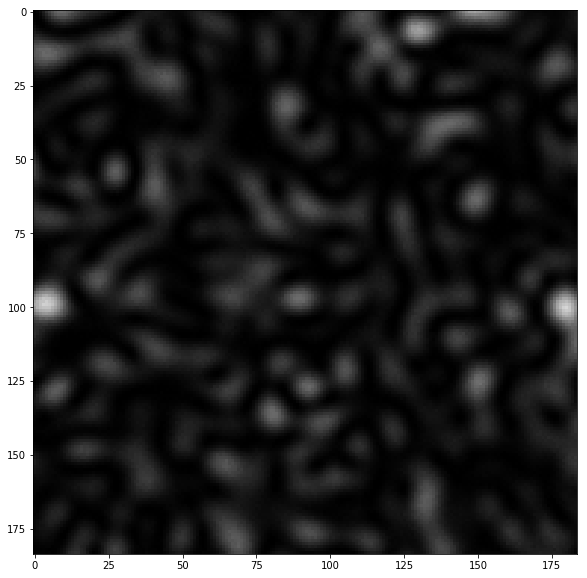

In [5]:
# Animate the image to check the simulated images

f1,ax = plt.subplots(1,1,figsize=(10,10));
max_val = np.max(Ic_image_up)

for i in range(0,40):
    if i != 1:
        ax.cla()
    ax.imshow(Ic_image_up[i],cmap='gray',vmin=0,vmax=max_val);
    display.display(f1);
    display.clear_output(wait=True);
    time.sleep(0.0001);

Text(0, 0.5, 'yshift (px)')

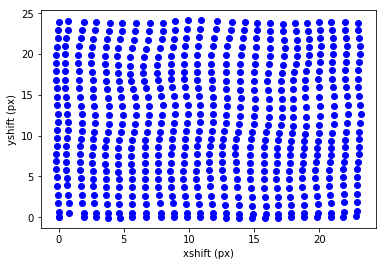

In [6]:
# image registration to get shift

xshift = np.zeros(Nimg)
yshift = np.zeros(Nimg)

for i in range(0,Nimg):
    if i == 1:
        yshift[i] == 0
        xshift[i] == 0
    else:
        output = dftregistration(fft2(Ic_image_up[0]),fft2(Ic_image_up[i]),100)
        yshift[i] = output[0]
        xshift[i] = output[1]
        
plt.plot(xshift,yshift,'bo')
plt.xlabel('xshift (px)')
plt.ylabel('yshift (px)')

In [7]:
# Initialization

xshift_max = np.int(np.round(np.max(abs(xshift))))
yshift_max = np.int(np.round(np.max(abs(yshift))))

I_obj = np.pad(np.mean(I_image_up,axis=0),(N_bound_pad,),mode='constant')
I_p_whole = np.ones((Nc+2*yshift_max, Mc+2*xshift_max))

Npp = Nc + 2*yshift_max
Mpp = Mc + 2*xshift_max


fxp = np.r_[-Mpp/2:Mpp/2]/ps/Mpp
fyp = np.r_[-Npp/2:Npp/2]/ps/Npp

fxxp, fyyp = np.meshgrid(fxp,fyp)

fxxp = ifftshift(fxxp)
fyyp = ifftshift(fyyp)

# Compute transfer function

Pupil_obj = np.zeros((Nc,Mc))
frc = (fxx_c**2 + fyy_c**2)**(1/2)
Pupil_obj[frc<NA_obj/lambda_f] = 1
T_incoherent = abs(fft2(abs(ifft2(Pupil_obj))**2))
T_incoherent = T_incoherent/np.max(T_incoherent)

# Compute Fourier support of the object and the pattern

NAs = 0.4
Pattern_support = np.zeros((Npp,Mpp))
frp = (fxxp**2 + fyyp**2)**(1/2)
Pattern_support[frp<2*NAs/lambda_f] = 1

Object_support = np.zeros((Nc,Mc))
Object_support[frc<2*(NA_obj+NAs)/lambda_f] = 1

OTF_support = np.zeros((Nc,Mc))
OTF_support[frc<2*NA_obj/lambda_f] = 1

# iteration number
itr = 20
err = np.zeros(itr+1)

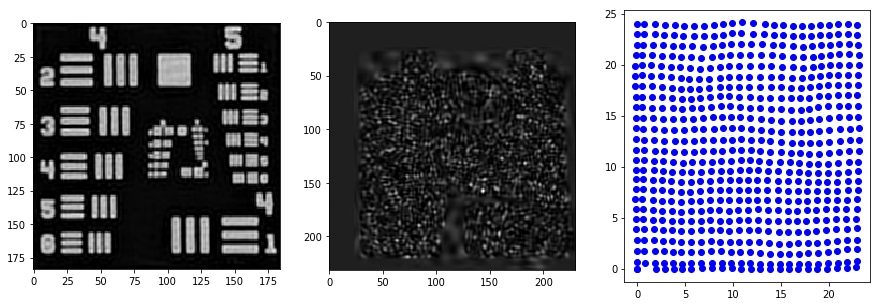

In [8]:
# Iterative algorithm

f1,ax = plt.subplots(1,3,figsize=(15,5))

tic_time = time.time()
print('|  Iter  |  error  |  Elapsed time (sec)  |')

for i in range(0,itr):
    
    # sequential update
    for j in range(0,Nimg):
        
        Ip_shift = np.maximum(0, np.real(ifft2(fft2(I_p_whole) * \
                              np.exp(1j*2*np.pi*ps*(fxxp * xshift[j] + fyyp * yshift[j])))))
        I_p = Ip_shift[yshift_max:Nc+yshift_max, xshift_max:Mc+xshift_max]
        I_image_current = I_image_up[j]
        I_multi_f = fft2(I_p * I_obj)
        I_est = ifft2(T_incoherent * I_multi_f)
        I_diff = I_image_current - I_est[N_bound_pad:N_bound_pad+N, N_bound_pad:N_bound_pad+M]
        
        I_temp = ifft2(T_incoherent * fft2(np.pad(I_diff,(N_bound_pad,),mode='constant')))
        
        # gradient computation
        grad_Iobj = -np.real(I_p * I_temp)
        grad_Ip = -np.real(ifft2(fft2(np.pad(I_obj * I_temp,((yshift_max,),(xshift_max,)), mode='constant'))\
                                 * np.exp(-1j*2*np.pi*ps*(fxxp * xshift[j] + fyyp * yshift[j]))))
#         grad_OTF = -np.conj(I_multi_f) * fft2(I_temp) * OTF_support
        
        # updating equation
        I_obj = np.real(ifft2(fft2(I_obj - grad_Iobj/(np.max(I_p)**2)) * Object_support))
        I_p_whole = np.real(ifft2(fft2(I_p_whole - grad_Ip/(np.max(I_obj)**2)) * Pattern_support))
#         T_incoherent = T_incoherent - grad_OTF/np.max(abs(I_multi_f)) * \
#         abs(I_multi_f) / (abs(I_multi_f)**2 + 1e-3) / 12
        
        # shift estimate
        Ip_shift_fx = ifft2(fft2(I_p_whole) * (1j*2*np.pi*fxxp) * \
                           np.exp(1j*2*np.pi*ps*(fxxp * xshift[j] + fyyp * yshift[j])))
        Ip_shift_fy = ifft2(fft2(I_p_whole) * (1j*2*np.pi*fyyp) * \
                           np.exp(1j*2*np.pi*ps*(fxxp * xshift[j] + fyyp * yshift[j])))
        Ip_shift_fx = Ip_shift_fx[yshift_max:yshift_max+Nc,xshift_max:xshift_max+Mc]
        Ip_shift_fy = Ip_shift_fy[yshift_max:yshift_max+Nc,xshift_max:xshift_max+Mc]
        
        grad_xshift = -np.real(np.sum(np.conj(I_temp) * I_obj * Ip_shift_fx))
        grad_yshift = -np.real(np.sum(np.conj(I_temp) * I_obj * Ip_shift_fy))
        
        xshift[j] = xshift[j] - grad_xshift/N/M/(np.max(I_obj)**2)
        yshift[j] = yshift[j] - grad_yshift/N/M/(np.max(I_obj)**2)
        
        err[i+1] += np.sum(abs(I_diff)**2)
    
    # Nesterov acceleration
    temp = I_obj.copy()
    temp_Ip = I_p_whole.copy()
    if i == 1:
        t = 1
        
        I_obj = temp.copy()
        tempp = temp.copy()
        
        I_p_whole = temp_Ip.copy()
        tempp_Ip = temp_Ip.copy()
    else:
        if err[i] >= err[i-1]:
            t = 1
        
            I_obj = temp.copy()
            tempp = temp.copy()
        
            I_p_whole = temp_Ip.copy()
            tempp_Ip = temp_Ip.copy()
        else:
            tp = t
            t = (1 + (1 + 4 * tp**2)**(1/2))/2

            I_obj = temp + (tp - 1) * (temp - tempp) / t
            tempp = temp.copy()

            I_p_whole = temp_Ip + (tp - 1) * (temp_Ip - tempp_Ip) / t
            tempp_Ip = temp_Ip.copy()

    if np.mod(i,1) == 0:
        print('|  %d  |  %.2e  |   %.2f   |'%(i,err[i+1],time.time()-tic_time))
        if i != 1:
            ax[0].cla()
            ax[1].cla()
            ax[2].cla()
        ax[0].imshow(np.maximum(0,I_obj),cmap='gray');
        ax[1].imshow(np.maximum(0,I_p_whole),cmap='gray')
        ax[2].plot(xshift,yshift,'bo')
        display.display(f1);
        display.clear_output(wait=True);
        time.sleep(0.0001);
        
    
        